In [1]:
# import os
# import pickle
# import pandas as pd
# import re
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental import preprocessing
import random
import typing
from typing import Any, Tuple
from tensorflow.python.framework.errors_impl import OperatorNotAllowedInGraphError
from preprocessing import load_data

In [2]:
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
    except RuntimeError as e:
        print(e)

random.seed(218)
super_folder = 'data_2021'
pkl_filename = 'stabilo_challenge_2021_part1+2.pkl'
DESIRED_SAMPLE_LENGTH = -1
LOG = True

MAX_ACC_FRONT = 32768
MAX_GYR = 32768
MAX_ACC_BACK = 8192
MAX_MAG = 8192
MAX_FORCE = 4096

def log(o=''):
    if LOG:
        print(o)



class ShapeChecker():
    def __init__(self):
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        if isinstance(names, str):
            names = (names,)
        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]
            if (broadcast and new_dim == 1):
                continue
            if old_dim is None:
                self.shapes[name] = new_dim
                continue
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")



1 Physical GPUs, 1 Logical GPUs


9477


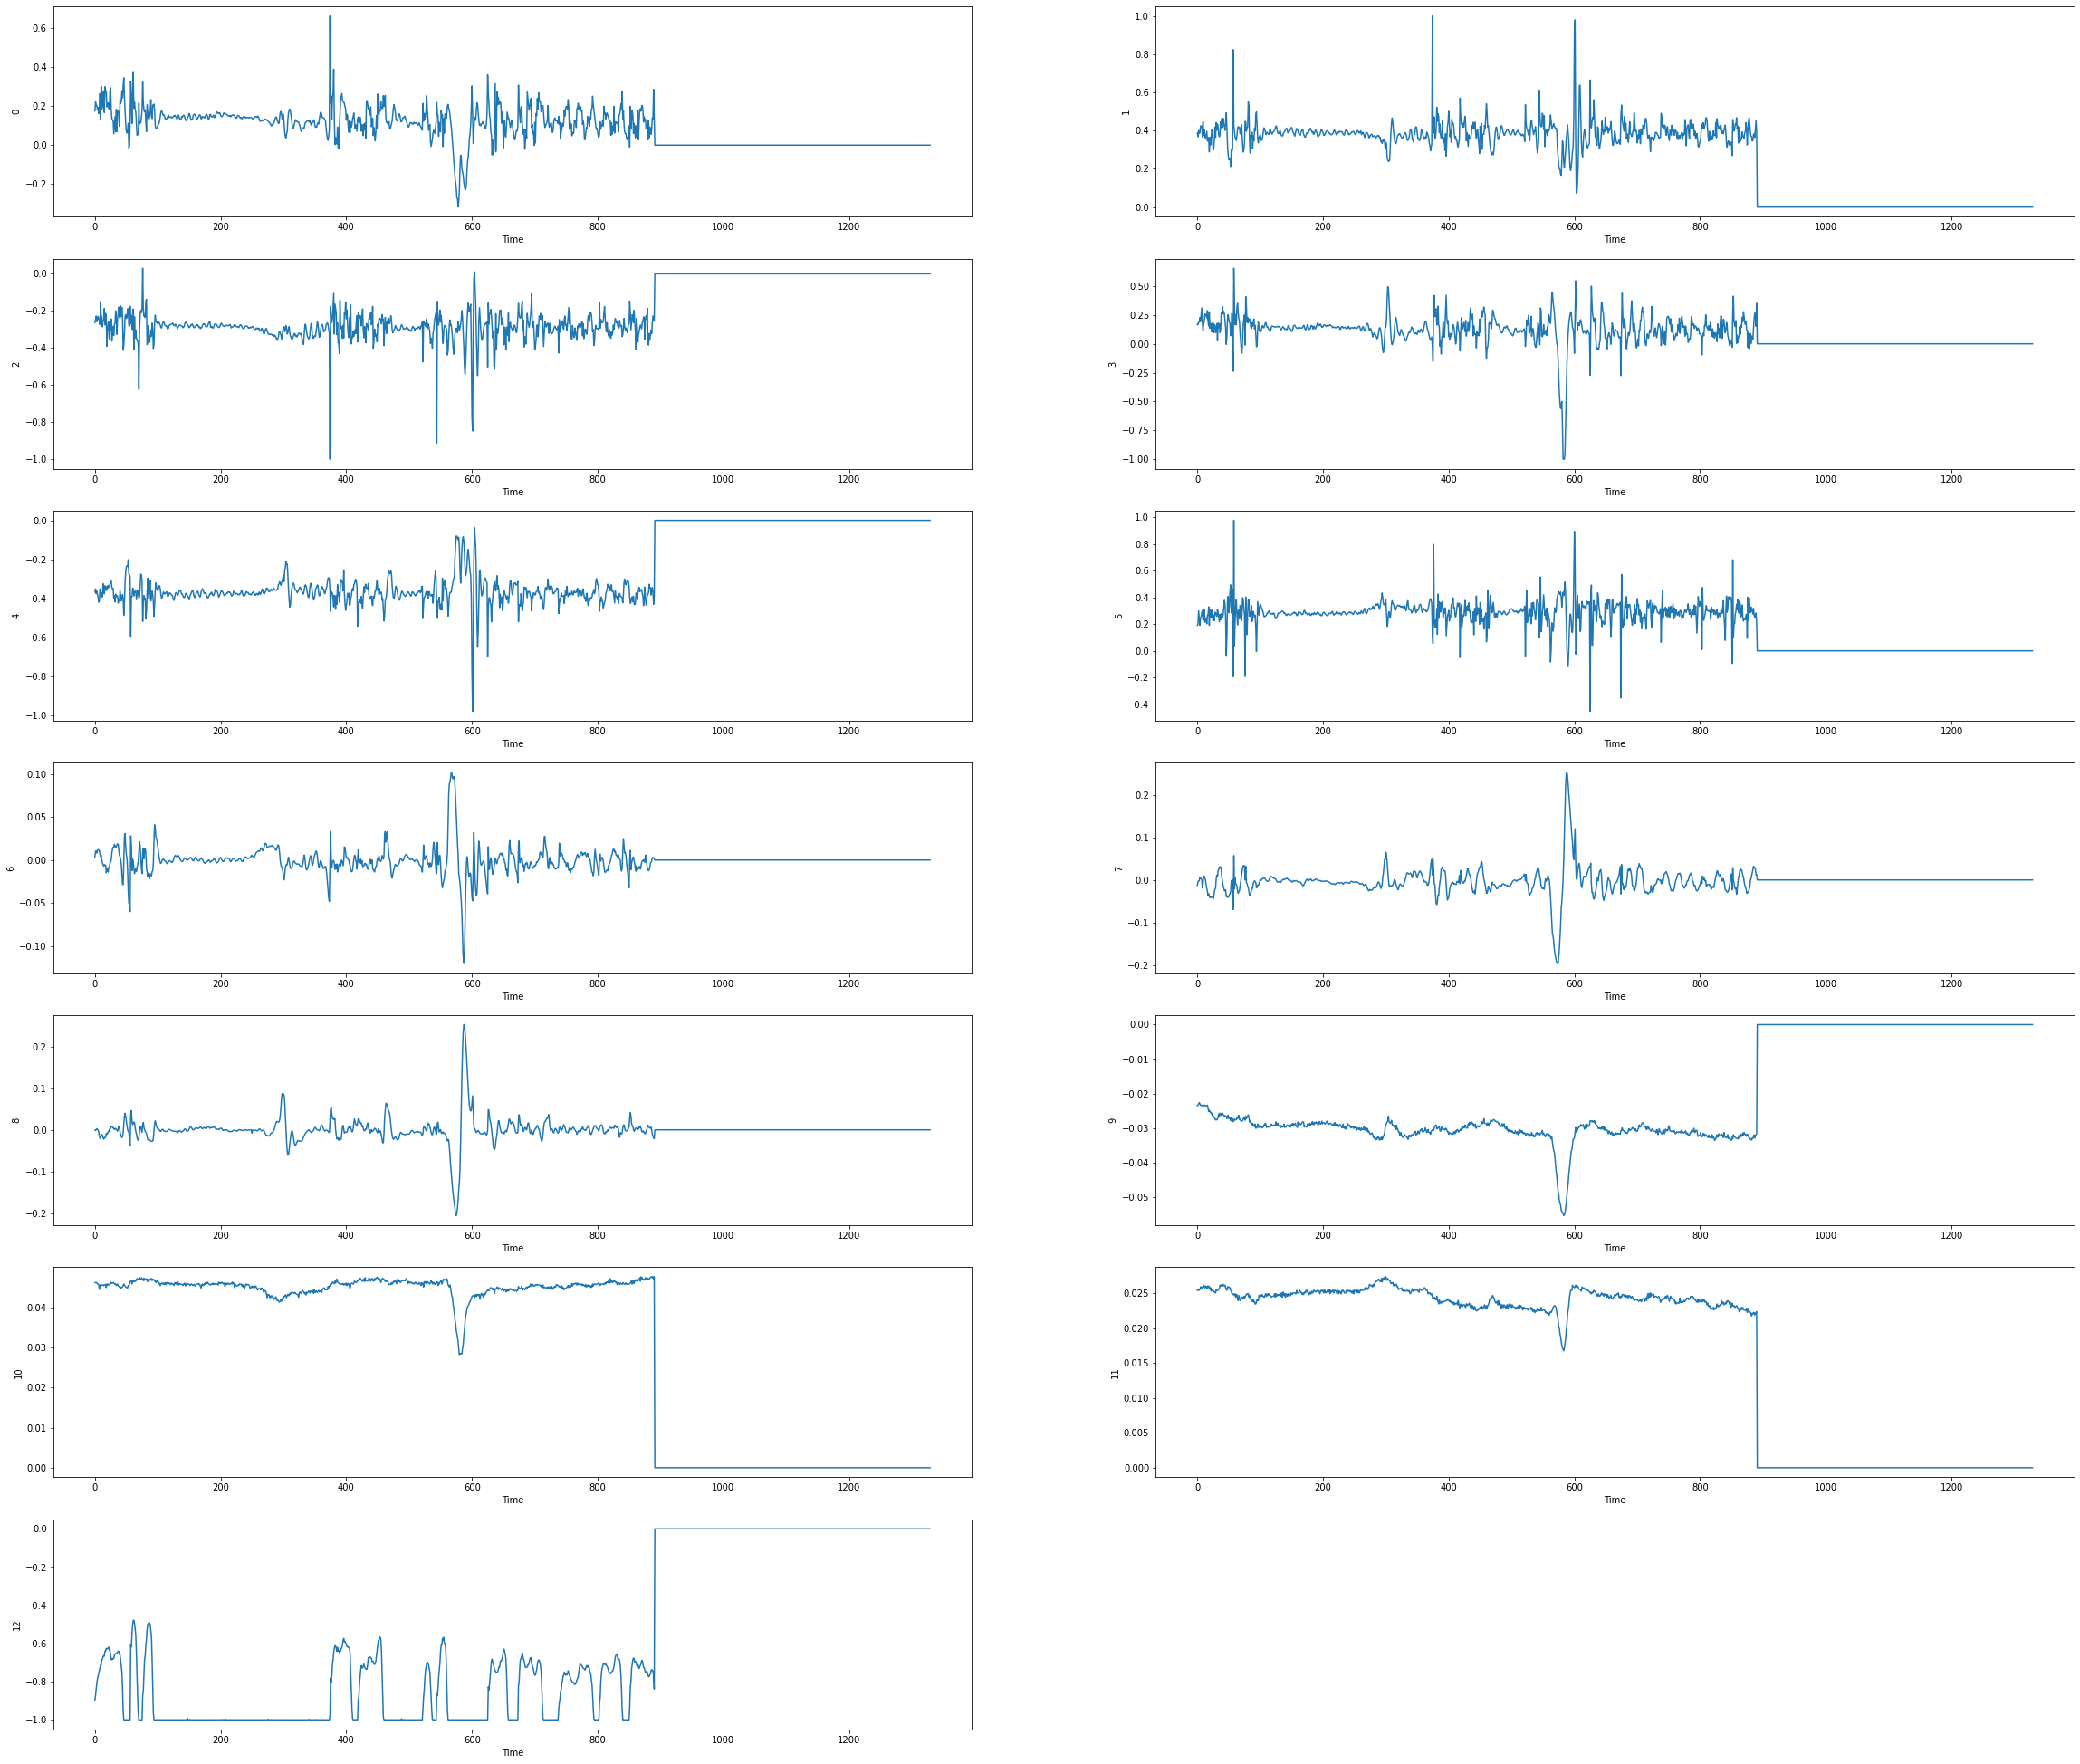

In [3]:
samples, labels = load_data()

In [4]:
def split_train_test(samples, labels):
    indices = list(range(len(samples)))
    random.shuffle(indices)
    sep_index = int((len(indices)/5)*4)
    train_indices, test_indices = indices[:sep_index], indices[sep_index:]
    train_samples, train_labels = [samples[i] for i in train_indices], [labels[i] for i  in train_indices]
    test_samples, test_labels = [samples[i] for i in test_indices], [labels[i] for i in test_indices]
    return train_samples, train_labels, test_samples, test_labels

In [5]:
train_samples, train_labels, test_samples, test_labels = split_train_test(samples, labels)
train_samples, train_labels, test_samples, test_labels = tf.constant(train_samples, dtype=np.float32), tf.constant(train_labels), tf.constant(test_samples, dtype=np.float32), tf.constant(test_labels)

log(train_labels[0])
log(test_labels[0])
TRAIN_BUFFER_SIZE = len(train_samples)
TEST_BUFFER_SIZE = len(test_samples)
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_samples, train_labels)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_samples, test_labels)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


tf.Tensor(b'8=4085:0', shape=(), dtype=string)
tf.Tensor(b'139717=90', shape=(), dtype=string)


In [6]:
log(len(train_dataset))
for example_input_batch, example_target_batch in train_dataset.take(1):
    log(example_input_batch[:5])
    log('')
    log(example_target_batch[:5])
    log('')
# example_input_batch = tf.convert_to_tensor(np.array(samples[:10]), dtype=np.float32)
# example_target_batch = np.array(labels[:10])

237
1
tf.Tensor(
[[[-0.03570557  0.42626953 -0.2578125  ...  0.0480957   0.02600098
   -0.890625  ]
  [-0.08795166  0.43920898 -0.23495483 ...  0.04833984  0.02612305
   -0.8413086 ]
  [-0.06002808  0.43988037 -0.2328186  ...  0.04797363  0.02563477
   -0.7963867 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.14068604  0.3717041  -0.31329346 ...  0.03552246 -0.01123047
   -0.8730469 ]
  [ 0.11032104  0.39086914 -0.28967285 ...  0.03588867 -0.01135254
   -0.8144531 ]
  [ 0.07003784  0.4104004  -0.3050537  ...  0.03564453 -0.01135254
   -0.75097656]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.22802734  0.4

In [7]:
# numeric labelling

def tf_lower_and_split_punct(text): # name of the function is from example on https://www.tensorflow.org/text/tutorials/nmt_with_attention#the_encoderdecoder_model
    # Add spaces around every item in the text.
    text = tf.strings.regex_replace(text, '.', r'\0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    )
output_text_processor.adapt(example_target_batch)
log(output_text_processor.get_vocabulary())

example_target_tokens = output_text_processor(example_target_batch)

['', '[UNK]', '[START]', '[END]', '4', '3', '5', '1', '9', '8', '6', '2', '-', '7', '0', '·', '=', ':', '+']


Text(0.5, 1.0, 'Mask')

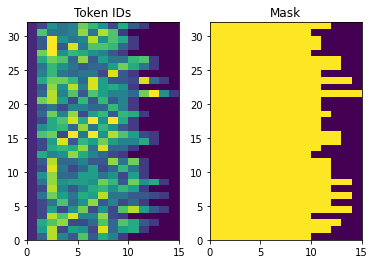

In [8]:
plt.subplot(1,2,1)
plt.pcolormesh(example_target_tokens)
plt.title('Token IDs')

plt.subplot(1,2,2)
plt.pcolormesh(example_target_tokens != 0)
plt.title('Mask')

In [9]:
embedding_dim = 8
units = 128

In [10]:
class Encoder(layers.Layer):
    def __init__(self, enc_units): # will be encoding the sensor data
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        # normally, with for example text, an embedding layer is needed to convert integer ids to a denser
        #  representation, but that layer has been left out for now, since the input is floats between [-1,1]
        # GRU RNN layer processes  vectors sequentially.
        # todo: replace with lstm?
        self.gru = layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,)
        # self.lstm = layers.LSTM(self.enc_units,
        #                         return_sequences=True,
        #                         return_state=True)

    def call(self, sensor_data, state=None):
        shape_checker = ShapeChecker()
        shape_checker(sensor_data, ('batch', 's', 'sensors'))
        output, state = self.gru(sensor_data, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        return output, state


In [11]:
# tokens = input_text_processor(labels) # already done earlier
example_tokens = example_input_batch
encoder = Encoder(units)
log('Encoder created')
example_enc_output, example_enc_state = encoder(example_input_batch)
log('gru done')

Encoder created
gru done


In [12]:
log(f'Input batch, shape (batch): {example_target_batch.shape}')
log(f'Input batch tokens, shape (batch, s): {example_target_tokens[:10].shape}')
log(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
log(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

Input batch, shape (batch): (32,)
Input batch tokens, shape (batch, s): (10, 15)
Encoder output, shape (batch, s, units): (32, 1330, 128)
Encoder state, shape (batch, units): (32, 128)


In [13]:
attention_layer = BahdanauAttention(units)
(example_tokens != 0).shape

TensorShape([32, 1330, 13])

In [14]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
# log(tf.map_fn(lambda xs: tf.map_fn(lambda x: all(x!=0), xs, fn_output_signature=tf.bool), example_tokens, fn_output_signature=tf.bool))
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=tf.reduce_any(example_tokens != tf.zeros(13), axis=2)
)

log(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
log(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (32, 2, 128)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (32, 2, 1330)


shape of attention weights: (32, 2, 1330)


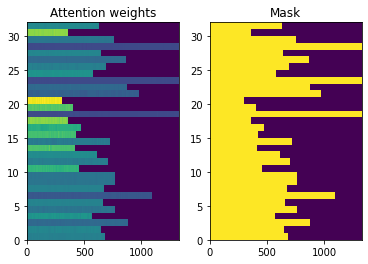

In [15]:
plt.subplot(1,2,1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')
plt.subplot(1,2,2)
plt.pcolormesh(tf.reduce_any(example_tokens != tf.zeros(13), axis=2))
plt.title('Mask')
log(f'shape of attention weights: {attention_weights.shape}')

<Figure size 432x288 with 0 Axes>

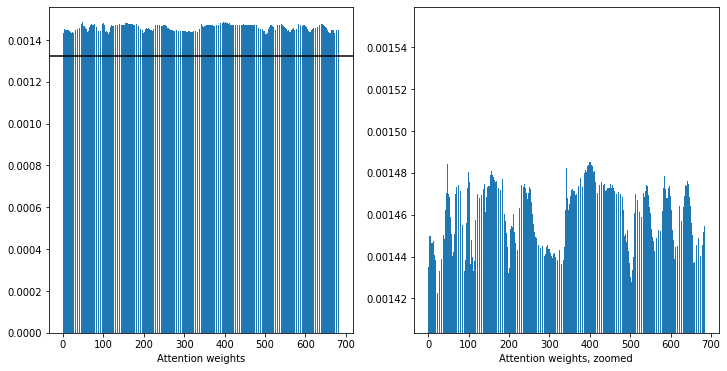

In [16]:
attention_slice = attention_weights[0,0].numpy()
attention_slice = attention_slice[attention_slice != 0]
plt.suptitle('Attention weights for one sequence')
plt.figure(figsize=(12, 6))
a1 = plt.subplot(1,2,1)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')
a2 = plt.subplot(1,2,2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [17]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any


class Decoder(layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = layers.Embedding(self.output_vocab_size,
                                          embedding_dim)

        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,)
        self.attention = BahdanauAttention(self.dec_units)
        self.Wc = tf.keras.layers.Dense(dec_units, activation = tf.math.tanh,
                                        use_bias=False)
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

    def call(self,
             inputs: DecoderInput,
             state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ('batch', 't'))
        shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
        shape_checker(inputs.mask, ('batch', 's'))
        if state is not None:
            shape_checker(state, ('batch', 'dec_units'))

        vectors = self.embedding(inputs.new_tokens)
        shape_checker(vectors, ('batch', 't', 'embedding_dim'))

        rnn_output, state = self.gru(vectors, initial_state=state)
        shape_checker(rnn_output, ('batch', 't', 'dec_units'))
        shape_checker(state, ('batch', 'dec_units'))

        context_vector, attention_weights = self.attention(
            query=rnn_output,
            value=inputs.enc_output,
            mask=inputs.mask)
        shape_checker(context_vector, ('batch', 't', 'dec_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

        attention_vector = self.Wc(context_and_rnn_output)
        shape_checker(attention_vector, ('batch', 't', 'dec_units'))

        logits = self.fc(attention_vector)
        shape_checker(logits, ('batch', 't', 'output_vocab_size'))

        return DecoderOutput(logits, attention_weights), state


In [18]:
decoder = Decoder(len(output_text_processor.get_vocabulary()),
                  embedding_dim, units)

example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

dec_result, dec_state = decoder(
    inputs=DecoderInput(new_tokens=first_token,
                        enc_output=example_enc_output,
                        mask=tf.reduce_any(example_tokens != tf.zeros(13), axis=2)),
    state=example_enc_state
)
log(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
log(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (32, 1, 19)
state shape: (batch_size, dec_units) (32, 128)


In [19]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)



In [20]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['5'],
       ['[START]'],
       [''],
       ['5'],
       ['']], dtype='<U7')

In [21]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none'
        )

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        return tf.reduce_sum(loss)

class MaskedSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='masked_sparse_categorical_accuracy', **kwargs):
        super(MaskedSparseCategoricalAccuracy, self).__init__(name=name, **kwargs)
        tf.keras.metrics.SparseCategoricalAccuracy
        self.sparse_categorical_accuracy = tf.keras.metrics.sparse_categorical_accuracy
        self.accuracy = tf.keras.metrics.Mean(name='mean_msca',dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
        # currently no need for sample_weights, but can be used in the future if necessary.
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        accuracy = self.sparse_categorical_accuracy(y_true, y_pred)
        shape_checker(accuracy, ('batch', 't'))
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        accuracy *= mask
        accuracy = tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
        self.accuracy.update_state(accuracy)

    def result(self):
        return self.accuracy.result()

    def reset_state(self):
        self.accuracy.reset_state()





In [22]:
class TrainTranslator(models.Model):
    def __init__(self, embedding_dim, units,
                 output_text_processor,
                 use_tf_function=True):
        super().__init__()
        encoder = Encoder(units)
        decoder = Decoder(len(output_text_processor.get_vocabulary()),
                          embedding_dim, units)
        self.encoder = encoder
        self.decoder = decoder
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self,inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    def test_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_test_step(inputs)
        else:
            return self._test_step(inputs)

    def _preprocess(self, input_sensor_data, target_text):
        self.shape_checker(input_sensor_data, ('batch', 's', 'sensors'))
        self.shape_checker(target_text, ('batch',))
        input_tokens = input_sensor_data
        target_tokens = self.output_text_processor(target_text)
        self.shape_checker(target_tokens, ('batch', 't'))
        # perhaps do an input mask, rather than resampling? just a possibility.
        input_mask = tf.reduce_any(input_tokens != tf.zeros(13), axis=2)
        self.shape_checker(input_mask, ('batch', 's'))
        target_mask = target_tokens != 0
        self.shape_checker(target_mask, ('batch', 't'))
        return input_tokens, input_mask, target_tokens, target_mask
    
    def _train_step(self, inputs):
        input_sensor_data, target_text = inputs
        (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_sensor_data, target_text)
        max_target_length = tf.shape(target_tokens)[1]
        with tf.GradientTape() as tape:
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
            self.shape_checker(enc_state, ('batch', 'enc_units'))
            dec_state = enc_state
            loss = tf.constant(0.0)
            for t in tf.range(max_target_length-1):
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                      enc_output, dec_state)
                loss = loss + step_loss
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        average_metrics = [m.result() for m in self.metrics]
        return {'batch_loss': average_loss, 'batch_accuracy': average_metrics[0]}
    
    def _test_step(self, inputs):
        input_sensor_data, target_text = inputs
        (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_sensor_data, target_text)
        max_target_length = tf.shape(target_tokens)[1]
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))
        dec_state = enc_state
        loss = tf.constant(0.0)
        for t in tf.range(max_target_length - 1):
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                   enc_output, dec_state)
            loss = loss + step_loss
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
        average_metrics = [m.result() for m in self.metrics]
        return {'batch_loss': average_loss, 'batch_accuracy': average_metrics[0]}

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.float32, shape=[None,None,13]), tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_test_step(self, inputs):
        return self._test_step(inputs)

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.float32, shape=[None,None,13]), tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
        decoder_input = DecoderInput(new_tokens=input_token,
                                     enc_output=enc_output,
                                     mask=input_mask)
        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
        self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        self.shape_checker(dec_state, ('batch', 'dec_units'))
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return step_loss, dec_state


In [23]:
np.log(len(output_text_processor.get_vocabulary()))
lr = 0.001

def train_test(train_arg, epochs=50):
    translator = TrainTranslator(
        embedding_dim, units,
        output_text_processor=output_text_processor,
    )
    translator.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=MaskedLoss(),
        metrics=[MaskedSparseCategoricalAccuracy()]
    )
    losses = []
    for n in range(epochs):
      print('.', end='')
      logs = translator.train_step(train_arg)
      losses.append(logs['batch_loss'].numpy())
    log('')
    plt.plot(losses)
    plt.show()
    return translator

def train_set(dataset, epochs=50):
    translator = TrainTranslator(
        embedding_dim, units,
        output_text_processor=output_text_processor,
    )
    translator.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=MaskedLoss(),
        metrics=[MaskedSparseCategoricalAccuracy()]
    )
    losses = []
    batches = list(iter(dataset))
    for n in range(epochs):
        for batch in batches:
            print('.', end='')
            logs = translator.train_step(batch)
            losses.append(logs['batch_loss'].numpy())
            # log(logs['batch_loss'])
        log('')

    log('')
    plt.plot(losses)
    plt.show()
    return translator

In [24]:

class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []
        self.val_logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])
    def on_test_batch_end(self, n, logs=None):
        self.val_logs.append(logs[self.key])

In [25]:

def fit_test(fit_arg, val_arg=None, epochs=200, train_translator=None,):
    if train_translator is None:
        train_translator = TrainTranslator(
            embedding_dim, units,
            output_text_processor=output_text_processor,
            use_tf_function=True,
        )
        train_translator.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr),
            loss=MaskedLoss(),
            metrics=[MaskedSparseCategoricalAccuracy()],
        )
    batch_loss = BatchLogs('batch_loss')
    batch_accuracy = BatchLogs('batch_accuracy')
    train_translator.fit(fit_arg, epochs=epochs, callbacks=[batch_loss, batch_accuracy], validation_data=val_arg)
    plt.plot(batch_loss.logs)
    # plt.ylim([0,3])
    plt.xlabel('Batch #')
    plt.ylabel('CE/token')
    plt.show()
    plt.plot(batch_loss.val_logs)
    plt.xlabel('Val Batch #')
    plt.ylabel('Val CE/token')
    plt.show()
    plt.plot(batch_accuracy.logs)
    plt.xlabel('Batch #')
    plt.ylabel('Accuracy')
    plt.show()
    plt.plot(batch_accuracy.val_logs)
    plt.xlabel('Val Batch #')
    plt.ylabel('Val Accuracy')
    plt.show()
    log(f'max batch_accuracy: {max(batch_accuracy.logs)}')
    log(f'max val_batch_accuracy: {max(batch_accuracy.val_logs)}')
    return train_translator, batch_loss, batch_accuracy 

Epoch 1/10
1/1 [==============================] - 25s 25s/step - batch_loss: 2.7054 - batch_accuracy: 0.0370 - val_batch_loss: 2.6765 - val_batch_accuracy: 0.0754
Epoch 2/10
1/1 [==============================] - 5s 5s/step - batch_loss: 2.6776 - batch_accuracy: 0.0841 - val_batch_loss: 2.6692 - val_batch_accuracy: 0.1085
Epoch 3/10
1/1 [==============================] - 5s 5s/step - batch_loss: 2.6681 - batch_accuracy: 0.0613 - val_batch_loss: 2.6462 - val_batch_accuracy: 0.0776
Epoch 4/10
1/1 [==============================] - 5s 5s/step - batch_loss: 2.6385 - batch_accuracy: 0.0679 - val_batch_loss: 2.6251 - val_batch_accuracy: 0.0707
Epoch 5/10
1/1 [==============================] - 5s 5s/step - batch_loss: 2.6280 - batch_accuracy: 0.0664 - val_batch_loss: 2.6119 - val_batch_accuracy: 0.0448
Epoch 6/10
1/1 [==============================] - 5s 5s/step - batch_loss: 2.6054 - batch_accuracy: 0.1140 - val_batch_loss: 2.6063 - val_batch_accuracy: 0.0449
Epoch 7/10
1/1 [================

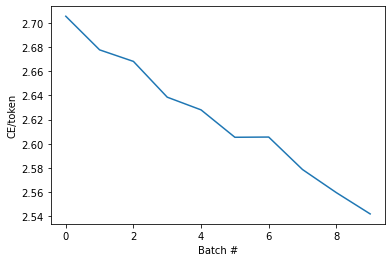

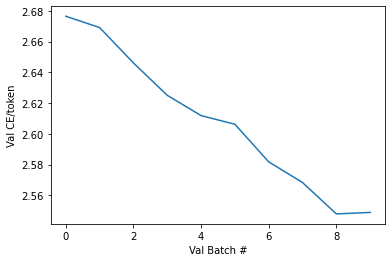

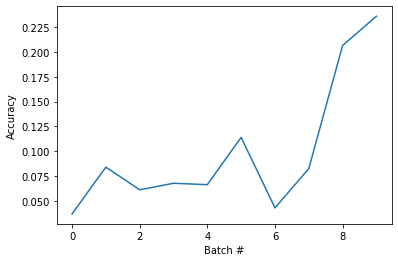

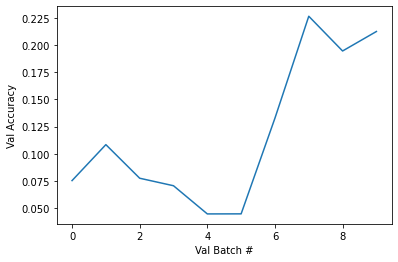

max batch_accuracy: 0.23572847247123718
max val_batch_accuracy: 0.22636885941028595
CPU times: user 1min 49s, sys: 12.3 s, total: 2min 1s
Wall time: 1min 16s


In [31]:
%%time
dummy_train_translator, dummy_batch_loss, dummy_batch_accuracy = fit_test(train_dataset.take(1), epochs=10, val_arg=test_dataset.take(1))
# test_batch_loss = train_translator.evaluate(test_dataset.take(1))


Epoch 1/50
237/237 [==============================] - 898s 4s/step - batch_loss: 2.3801 - batch_accuracy: 0.2154 - val_batch_loss: 2.2914 - val_batch_accuracy: 0.2586
Epoch 2/50
237/237 [==============================] - 868s 4s/step - batch_loss: 2.2851 - batch_accuracy: 0.2616 - val_batch_loss: 2.2919 - val_batch_accuracy: 0.2594
Epoch 3/50
237/237 [==============================] - 860s 4s/step - batch_loss: 2.2734 - batch_accuracy: 0.2645 - val_batch_loss: 2.2605 - val_batch_accuracy: 0.2620
Epoch 4/50
237/237 [==============================] - 856s 4s/step - batch_loss: 2.2648 - batch_accuracy: 0.2668 - val_batch_loss: 2.2801 - val_batch_accuracy: 0.2652
Epoch 5/50
237/237 [==============================] - 869s 4s/step - batch_loss: 2.2589 - batch_accuracy: 0.2691 - val_batch_loss: 2.2435 - val_batch_accuracy: 0.2608
Epoch 6/50
237/237 [==============================] - 860s 4s/step - batch_loss: 2.2543 - batch_accuracy: 0.2680 - val_batch_loss: 2.3219 - val_batch_accuracy: 0.268

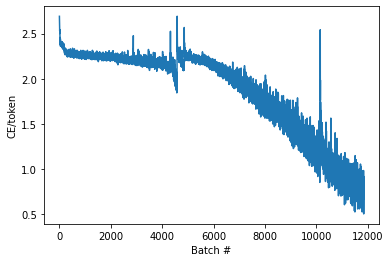

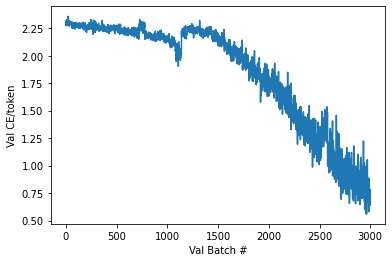

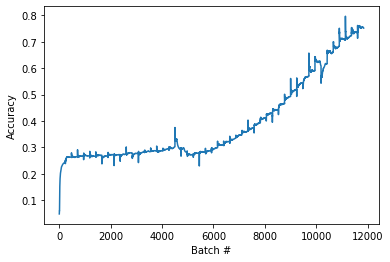

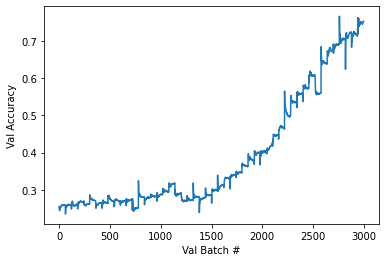

max batch_accuracy: 0.7961805462837219
max val_batch_accuracy: 0.767611563205719
CPU times: user 21h 37min 3s, sys: 3h 7min 35s, total: 1d 44min 39s
Wall time: 11h 48min 10s


In [26]:
%%time
#data_train, data_test = dataset.take(len(dataset))
train_translator, batch_loss, batch_accuracy = fit_test(train_dataset, val_arg=test_dataset, epochs=50)

In [27]:
log(train_translator.evaluate(test_dataset))

60/60 [==============================] - 32s 519ms/step - batch_loss: 0.7560 - batch_accuracy: 0.7603
[0.7579346895217896, 0.6169038414955139]


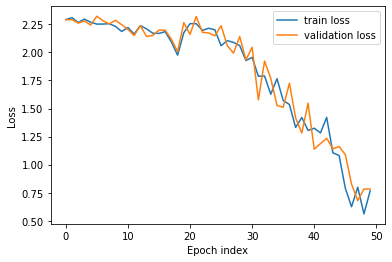

2.309004068374634
2.2536332607269287


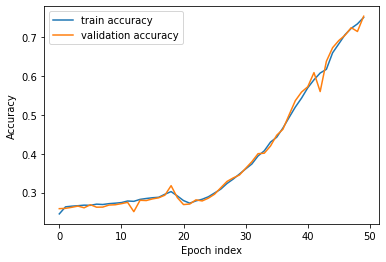

0.7513861656188965
0.7103525996208191


In [73]:

# we take one loss log in every n batches, where n is the number of batches per epoch. We do this because batch n is the total average of the epoch.

plt.plot(batch_loss.logs[len(train_dataset)-1::len(train_dataset)])
plt.plot(batch_loss.val_logs[len(test_dataset)-1::len(test_dataset)])
plt.xlabel('Epoch index')
plt.ylabel('Loss')
plt.legend(['train loss', 'validation loss'])
plt.show()
log(max(batch_loss.logs[len(train_dataset)-1::len(train_dataset)]))
log(max(batch_loss.val_logs[len(train_dataset)-1::len(train_dataset)]))

plt.plot(batch_accuracy.logs[len(train_dataset)-1::len(train_dataset)])
plt.plot(batch_accuracy.val_logs[len(test_dataset)-1::len(test_dataset)])
plt.xlabel('Epoch index')
plt.ylabel('Accuracy')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()
log(max(batch_accuracy.logs[len(train_dataset)-1::len(train_dataset)]))
log(max(batch_accuracy.val_logs[len(train_dataset)-1::len(train_dataset)]))


In [28]:

class Translator(tf.Module):
    def __init__(self,
                 encoder, decoder,
                 output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.output_text_processor = output_text_processor
        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                invert=True))
        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary())
        token_mask_ids = index_from_string(['',
                                            '[UNK]',
                                            '[START]']).numpy()
        token_mask = np.zeros([len(index_from_string.get_vocabulary())], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        self.start_token = index_from_string('[START]')
        self.end_token = index_from_string('[END]')

    def tokens_to_text(self, result_tokens):
        shape_checker = ShapeChecker()
        shape_checker(result_tokens, ('batch', 't'))
        result_text_tokens = self.output_token_string_from_index(result_tokens)
        shape_checker(result_text_tokens, ('batch', 't'))
        result_text = tf.strings.reduce_join(result_text_tokens,
                                            axis=1, separator=' ')
        shape_checker(result_text, ('batch'))
        result_text = tf.strings.strip(result_text)
        shape_checker(result_text, ('batch',))
        return result_text
    
    def sample(self, logits, temperature):
        shape_checker = ShapeChecker()
        shape_checker(logits, ('batch', 't', 'vocab'))
        shape_checker(self.token_mask, ('vocab',))
        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
        shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
        logits = tf.where(self.token_mask, -np.inf, logits)
        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else:
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature,
                                              num_samples=1)
        shape_checker(new_tokens, ('batch', 't'))
        return new_tokens
    
    # using tf.function annotation allows tensorflow to trace the function and speed things up significantly. Debuggin becomes harder though, so
    #  if you want to debug, comment out this kind of annotation.
    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.float32, shape=[BATCH_SIZE,None,13]), tf.TensorSpec(dtype=tf.string, shape=[BATCH_SIZE])]])
    def tf_translate(self, inputs):
        return self.translate(inputs)

    def translate(self,
                  inputs, *,
                  max_length=50,
                  return_attention=True,
                  temperature=1.0):
        input_sensor_data, target_text = inputs
        batch_size = tf.shape(input_sensor_data)[0]
        input_tokens = input_sensor_data
        enc_output, enc_state = self.encoder(input_tokens)
        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.strart_token)
        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                    enc_output=enc_output,
                                    mask=tf.reduce_any(input_tokens != tf.zeros(13), axis=2))
            dec_result, dec_state = self.decoder(dec_input, state=dec_state)
            attention.append(dec_result.attention_weights)
            new_tokens = self.sample(dec_result.logits, temperature)
            done = done | (new_tokens == self.end_token)
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
            result_tokens.append(new_tokens)
            if tf.executing_eagerly() and tf.reduce_all(done):
                break
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)
        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

In [29]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    output_text_processor=train_translator.output_text_processor,
)


In [30]:
example_output_tokens = tf.random.uniform(shape=[5,2], minval=0, dtype=tf.int64,
                                       maxval=len(output_text_processor.get_vocabulary()))
translator.tokens_to_text(example_output_tokens)

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'= 5', b'0 [END]', b'4 9', b'[END] 9', b'1 [END]'], dtype=object)>

In [31]:
example_logits = tf.random.normal([5, 1, len(output_text_processor.get_vocabulary())])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[10],
       [11],
       [ 8],
       [18],
       [ 5]])>

In [32]:
%%time
inputs = next(iter(test_dataset.take(1)))
result = translator.tf_translate(inputs=inputs)
for item in zip(inputs[1], result['text']):
    log(f'label: {item[0].numpy().decode()}  prediction: {item[1].numpy().decode()}')


AttributeError: in user code:

    <ipython-input-28-3764b27c8b26>:55 tf_translate  *
        return self.translate(inputs)
    <ipython-input-28-3764b27c8b26>:67 translate  *
        new_tokens = tf.fill([batch_size, 1], self.strart_token)

    AttributeError: 'Translator' object has no attribute 'strart_token'


In [ ]:
a = result['attention'][0]
print(np.sum(a, axis=-1))

log(len(a))
_ = plt.bar(range(len(a[0, :])), a[0, :])
plt.show()
plt.imshow(np.transpose(np.array(a)), vmin=0.0, )

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    predicted_sentence = [c for c in predicted_sentence.numpy().decode()] + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels(range(len(sentence)+1), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')


i=0
log(inputs[0][0])
plot_attention(result['attention'][i][:10], inputs[0][i][:10], result['text'][i])

In [33]:
tf.saved_model.save(translator, 'saved_models/translator',
                   signatures={'serving_default': translator.tf_translate})

AttributeError: in user code:

    <ipython-input-28-3764b27c8b26>:55 tf_translate  *
        return self.translate(inputs)
    <ipython-input-28-3764b27c8b26>:67 translate  *
        new_tokens = tf.fill([batch_size, 1], self.strart_token)

    AttributeError: 'Translator' object has no attribute 'strart_token'


In [ ]:
reloaded = tf.saved_model.load('saved_models/translator')

In [ ]:
result = reloaded.tf_translate(inputs)

In [ ]:
i=0
log(inputs[0][0])
plot_attention(result['attention'][i][:50], inputs[0][i][:50], result['text'][i])